In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar  4 05:53:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Starting

In [3]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [5]:
# Load the data
from keras.datasets import mnist
data = pd.read_csv('/content/drive/MyDrive/Datasets/digits.csv')

In [6]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data.shape

(42000, 785)

In [8]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

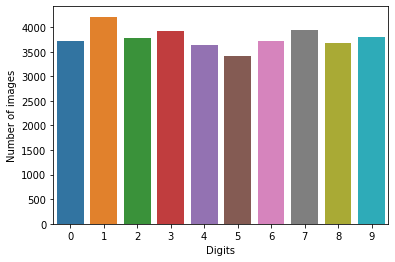

In [9]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [10]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [11]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [12]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1])

Let's print some example images.

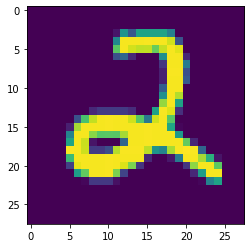

In [13]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

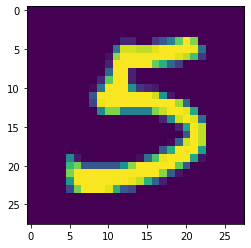

In [14]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

In [47]:
# model analysis functions
#Function for model evaluation
# Model analysis modules
import sklearn
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, f1_score
# Function For analysing model
def analyse(model, x_data, y_data, data_title):
    pred = model.predict(x_data)
    #cm = confusion_matrix(y_data, pred)
    print(f'For {data_title} data')
    Accuracy  = (accuracy_score(y_data, pred)).round(4)
    Precision  = (precision_score(y_data, pred, average = 'micro')).round(4)  
    Sensitivity = (recall_score(y_data, pred,  average = 'micro')).round(4)
    F1 = f1_score(y_data, pred,  average = 'micro').round(4)
   
    
    
    #mat = pd.DataFrame(cm)
    
    
    print('Accuracy:',Accuracy)
    print('Precision:',Precision)
    print('Sensitivity:',Sensitivity)
    print('F1:', F1)
    
    

## Define CNN Model

In [29]:
# function to create the CNN

def create_cnn(learning_rate= 0.01, num_dense_layers = 2, num_dense_nodes= 52,activation='relu'):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function only.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same', input_shape=(28, 28, 1),
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we will only optimize the activation function.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(learning_rate=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
cnn1 = create_cnn(learning_rate= 0.01, num_dense_layers = 2, num_dense_nodes= 52,activation='relu')
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_conv1 (Conv2D)        (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 layer_conv2 (Conv2D)        (None, 14, 14, 36)        14436     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 36)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1764)              0         
                                                                 
 dense (Dense)               (None, 52)                9

In [30]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_cnn, epochs=25, batch_size=10, verbose=0)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
model.fit(X_train, y_train)


In [40]:
analyse(model, X_train, y_train, 'Training')

For Training data
Accuracy: 0.6724
Precision: 0.6724
Sensitivity: 0.6724
F1: 0.6724


In [41]:
analyse(model, X_test, y_test, 'Testing')

For Testing data
Accuracy: 0.6717
Precision: 0.6717
Sensitivity: 0.6717
F1: 0.6717


In [17]:
from scipy import stats
import numpy as np
param_dist = {'num_dense_nodes':stats.randint(10, 500),
          'activation':np.random.choice(['sigmoid','relu'],1),
          'num_dense_layers':stats.randint(2, 6),
          'learning_rate':stats.uniform(1e-6, 1e-2)}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(model, param_dist, cv = 2, n_iter = 20, refit = True, scoring = 'accuracy')
import time

start = time.time()
random_search.fit(X_train, y_train)
end = time.time()
fit_time = end - start
print('Fit_time: ', fit_time)

Fit_time:  5609.338055849075


In [19]:
random_search.best_params_

{'activation': 'relu',
 'learning_rate': 0.0014501016196374727,
 'num_dense_layers': 2,
 'num_dense_nodes': 465}

In [42]:
# function to create the CNN

def create_cnn(learning_rate=  0.0014501016196374727, num_dense_layers = 2, num_dense_nodes= 465,activation='relu'):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function only.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same', input_shape=(28, 28, 1),
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we will only optimize the activation function.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(learning_rate=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
es = EarlyStopping( monitor="accuracy", min_delta=0.001, patience=5, verbose=0)
model = KerasClassifier(build_fn=create_cnn, epochs=50, batch_size=10, verbose=0, callbacks= es)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


In [44]:
model.fit(X_train, y_train)


In [48]:
analyse(model, X_train, y_train, 'Training')

For Training data
Accuracy: 0.9973
Precision: 0.9973
Sensitivity: 0.9973
F1: 0.9973


In [49]:
analyse(model, X_test, y_test, 'Testing')

For Testing data
Accuracy: 0.9852
Precision: 0.9852
Sensitivity: 0.9852
F1: 0.9852
